In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch
from sklearn.metrics import cohen_kappa_score,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
import numpy as np
import argparse
import pandas as pd

In [2]:
device = 2

In [3]:
torch.cuda.set_device(device)


path = Path('datasetCitologia/')

trainPath = path/'train'
testPath = path/'test'

In [4]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
             get_items=get_image_files, 
             splitter=RandomSplitter(valid_pct=0.2,seed=42),
             get_y=parent_label,
             item_tfms = [Resize(640)], # CropPad(200,200)
             batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                  max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)])

In [5]:
name = 'resnet50d'

In [8]:
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname=name+'fl_noearly',monitor='accuracy'),MixUp(),
    ReduceLROnPlateau(patience=3)
]

In [9]:
dls = db.dataloaders(trainPath,bs=16)

learn = Learner(dls,timm.create_model(name,num_classes=2,pretrained=True,drop_rate=0.5),
            metrics=[accuracy,Precision(),Precision(pos_label=0),Recall(),Recall(pos_label=0),F1Score(),RocAucBinary(),CohenKappa()],
            cbs=callbacks,
            loss_func= FocalLossFlat()).to_fp16()

Better model found at epoch 0 with accuracy value: 0.8146964907646179.


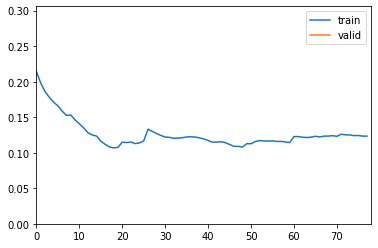

Better model found at epoch 0 with accuracy value: 0.8753993511199951.


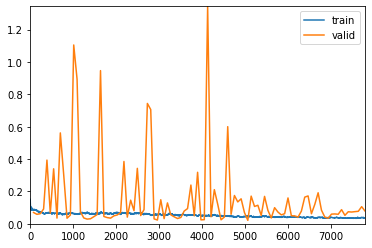

Better model found at epoch 1 with accuracy value: 0.8817891478538513.
Better model found at epoch 2 with accuracy value: 0.9073482155799866.
Epoch 4: reducing lr to 3.7998244853982404e-05
Better model found at epoch 5 with accuracy value: 0.9297124743461609.
Better model found at epoch 7 with accuracy value: 0.9584664702415466.
Epoch 13: reducing lr to 8.364817750199017e-05
Better model found at epoch 15 with accuracy value: 0.9680511355400085.
Epoch 19: reducing lr to 0.00011993020254801208
Epoch 22: reducing lr to 0.00013453474455529866
Epoch 25: reducing lr to 0.0001447799088285674
Epoch 28: reducing lr to 0.00014966283775540317
Epoch 31: reducing lr to 0.00014970193163707244
Epoch 34: reducing lr to 0.00014812920440993347
Epoch 40: reducing lr to 0.00014106519521746617
Epoch 43: reducing lr to 0.0001357017763617347
Epoch 46: reducing lr to 0.0001292396377129352
Epoch 49: reducing lr to 0.00012179575427628979
Epoch 52: reducing lr to 0.00011350484459028403
Epoch 55: reducing lr to 

In [10]:
learn.fine_tune(100,base_lr=3e-3)

In [11]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                 max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=16)
learn.dls = dlsTest

learn.validate()

Better model found at epoch 0 with accuracy value: 1.0.


(#9) [0.056359343230724335,0.9563106894493103,1.0,0.9491525423728814,0.7631578947368421,1.0,0.8656716417910448,0.9626801378446115,0.8401448525607864]

In [57]:
preds,gt= learn.get_preds()

In [13]:
np.argmax(preds,axis=1)

tensor([0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

datasetCitologia/test/maligno/12_1005205.jpg
Predicted as tensor(0) with probability tensor([0.5500, 0.4500]), but actual value was tensor(1)
datasetCitologia/test/maligno/1_1005126.jpg
Predicted as tensor(0) with probability tensor([0.5049, 0.4951]), but actual value was tensor(1)
datasetCitologia/test/maligno/0_1005205.jpg
Predicted as tensor(0) with probability tensor([0.5657, 0.4343]), but actual value was tensor(1)
datasetCitologia/test/maligno/7_1005131.jpg
Predicted as tensor(0) with probability tensor([0.8604, 0.1396]), but actual value was tensor(1)
datasetCitologia/test/maligno/1_1005131.jpg
Predicted as tensor(0) with probability tensor([0.8471, 0.1529]), but actual value was tensor(1)
datasetCitologia/test/maligno/2_1005131.jpg
Predicted as tensor(0) with probability tensor([0.7991, 0.2009]), but actual value was tensor(1)
datasetCitologia/test/maligno/6_1005131.jpg
Predicted as tensor(0) with probability tensor([0.9778, 0.0222]), but actual value was tensor(1)
datasetCitol

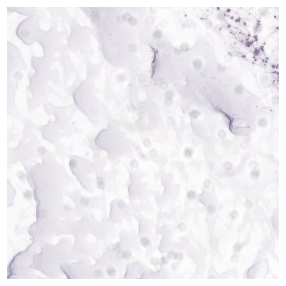

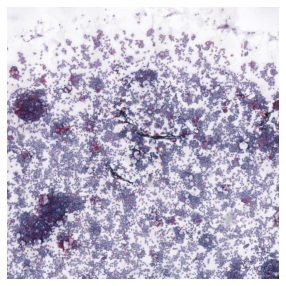

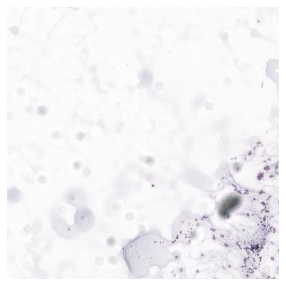

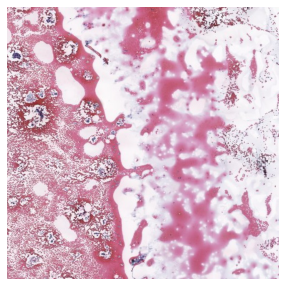

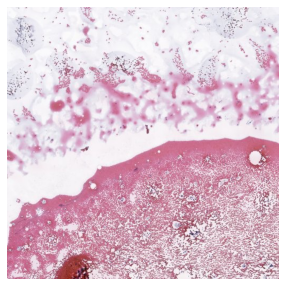

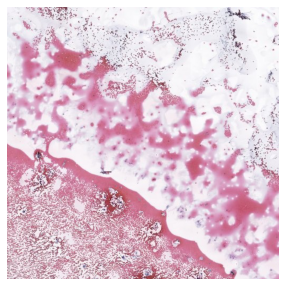

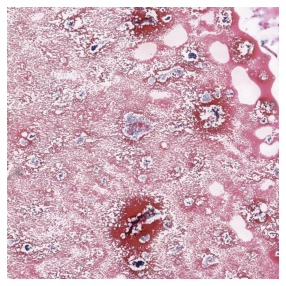

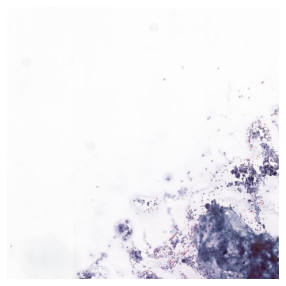

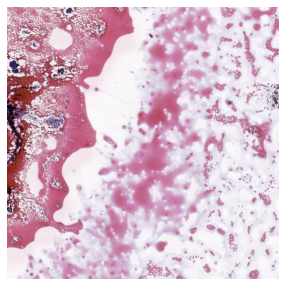

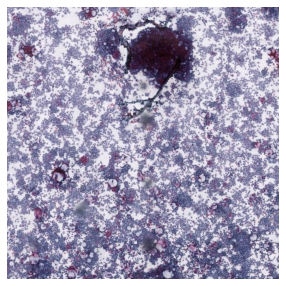

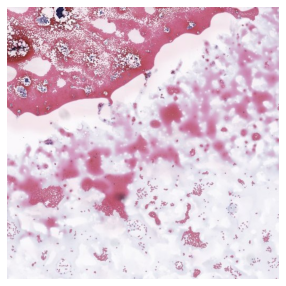

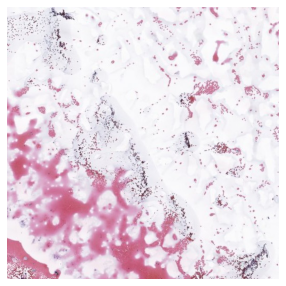

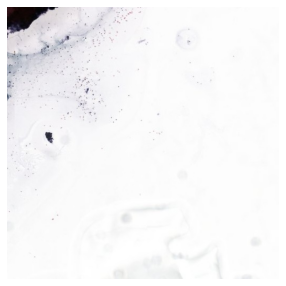

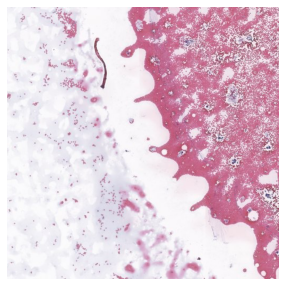

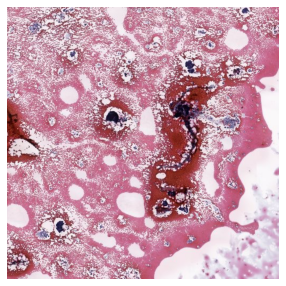

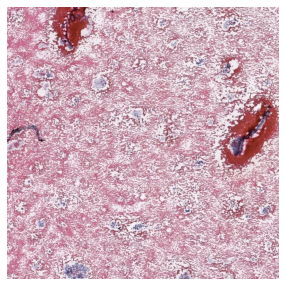

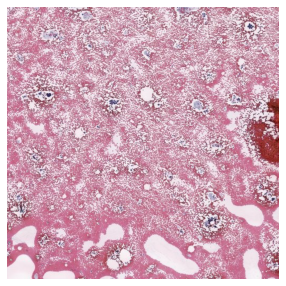

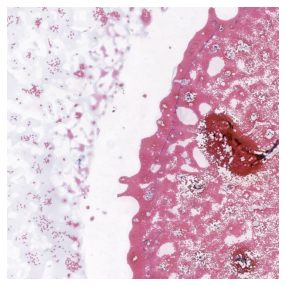

In [61]:
for i,(gtValue,predValue,imagePath) in enumerate(zip(gt,np.argmax(preds,axis=1),list(dlsTest.valid_ds.items))):
    if(gtValue!=predValue):
        print(imagePath)
        print('Predicted as ' + str(predValue) + ' with probability ' + str(preds[i]) + ', but actual value was ' + str(gtValue))
        image = PILImage.create(imagePath)
        image.show()

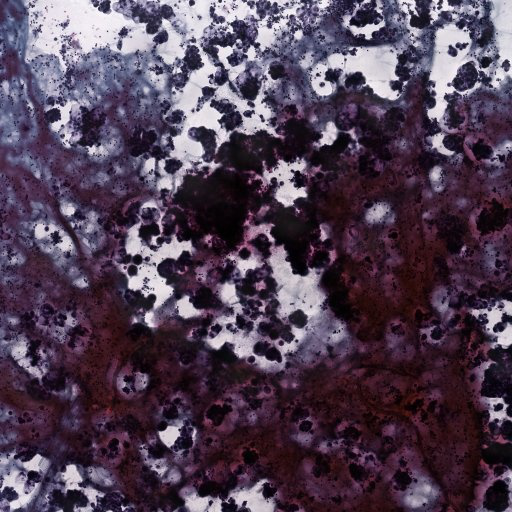

In [103]:
PILImage.create('datasetCitologia/test/maligno/'+str(5)+'_1005132.jpg')

In [99]:
learn.predict('datasetCitologia/test/maligno/'+str(10)+'_1005131.jpg')

('benigno', tensor(0), tensor([0.8184, 0.1816]))

In [93]:
for i in range(0,16):
    print(learn.predict('datasetCitologia/test/maligno/'+str(i)+'_1005131.jpg'))

('maligno', tensor(1), tensor([0.3258, 0.6742]))


('benigno', tensor(0), tensor([0.8472, 0.1528]))


('benigno', tensor(0), tensor([0.7991, 0.2009]))


('benigno', tensor(0), tensor([0.5193, 0.4807]))


('benigno', tensor(0), tensor([0.8046, 0.1954]))


('benigno', tensor(0), tensor([0.9918, 0.0082]))


('benigno', tensor(0), tensor([0.9778, 0.0222]))


('benigno', tensor(0), tensor([0.8605, 0.1395]))


('benigno', tensor(0), tensor([0.6451, 0.3549]))


('benigno', tensor(0), tensor([0.9788, 0.0212]))


('benigno', tensor(0), tensor([0.8184, 0.1816]))


('benigno', tensor(0), tensor([0.6644, 0.3356]))


('maligno', tensor(1), tensor([0.2302, 0.7698]))


('maligno', tensor(1), tensor([0.4639, 0.5361]))


('benigno', tensor(0), tensor([0.5486, 0.4514]))


('maligno', tensor(1), tensor([0.3790, 0.6210]))


In [79]:
!ls datasetCitologia/test/maligno

0_1005126.jpg	11_1005131.jpg	15_1005131.jpg	4_1005132.jpg  7_1005205.jpg
0_1005131.jpg	11_1005132.jpg	15_1005132.jpg	4_1005205.jpg  7_1005215.jpg
0_1005132.jpg	11_1005205.jpg	15_1005205.jpg	4_1005215.jpg  8_1005126.jpg
0_1005205.jpg	11_1005215.jpg	15_1005215.jpg	5_1005126.jpg  8_1005131.jpg
0_1005215.jpg	12_1005131.jpg	2_1005126.jpg	5_1005131.jpg  8_1005132.jpg
10_1005126.jpg	12_1005132.jpg	2_1005131.jpg	5_1005132.jpg  8_1005205.jpg
10_1005131.jpg	12_1005205.jpg	2_1005132.jpg	5_1005205.jpg  8_1005215.jpg
10_1005132.jpg	12_1005215.jpg	2_1005205.jpg	5_1005215.jpg  9_1005126.jpg
10_1005205.jpg	13_1005131.jpg	2_1005215.jpg	6_1005126.jpg  9_1005131.jpg
10_1005215.jpg	13_1005132.jpg	3_1005126.jpg	6_1005131.jpg  9_1005132.jpg
1_1005126.jpg	13_1005205.jpg	3_1005131.jpg	6_1005132.jpg  9_1005205.jpg
1_1005131.jpg	13_1005215.jpg	3_1005132.jpg	6_1005205.jpg  9_1005215.jpg
1_1005132.jpg	14_1005131.jpg	3_1005205.jpg	6_1005215.jpg
1_1005205.jpg	14_1005132.jpg	3_1005215.jpg	7_1005126.jpg
1_1005215.jpg

In [20]:
from matplotlib.colors import LinearSegmentedColormap

from fastai.vision.all import *

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
import torchvision.transforms as transforms

import timm

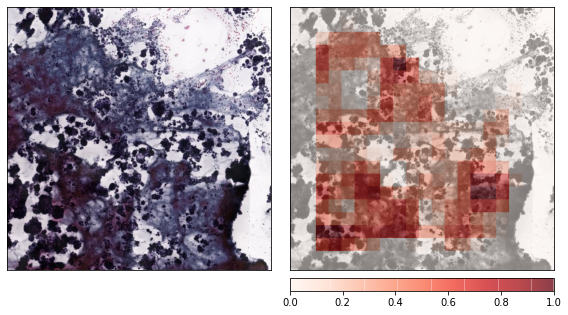

In [108]:
name = 'datasetCitologia/test/maligno/'+str(6)+'_1005132.jpg'
img = PILImage.create(name)
x, = first(dlsTest.test_dl([img]))
pred,pred_idx,probs =learn.predict(img)
occlusion = Occlusion(learn.model)

attr_occ = occlusion.attribute(x,
                               strides = (3, 25, 25),
                               target=pred_idx,
                               sliding_window_shapes=(3,50, 50),
                               baselines=0)

image = transforms.Resize((512,512))(img)
attr_occ1= np.transpose(attr_occ.cpu().squeeze().numpy(), (1,2,0))

im,_ = viz.visualize_image_attr_multiple(np.transpose(attr_occ.cpu().squeeze().numpy(), (1,2,0)),#np.where(attr_occ>0.05,attr_occ,0)
                                  image,
                                  ["original_image", "blended_heat_map"],
                                  ["all", "negative"],
                                  show_colorbar=True,
                                  outlier_perc=2,
                                 )

In [110]:
integrated_gradients = IntegratedGradients(learn.model)

In [112]:
attributions_ig = integrated_gradients.attribute(x, target=pred_idx, n_steps=100)


RuntimeError: CUDA out of memory. Tried to allocate 800.00 MiB (GPU 2; 10.73 GiB total capacity; 7.50 GiB already allocated; 385.56 MiB free; 9.35 GiB reserved in total by PyTorch)